In [13]:
import pandas as pd
import numpy as np
import os
from neo4j import GraphDatabase
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.metrics.pairwise import euclidean_distances as euclidean
from sklearn.metrics.pairwise import manhattan_distances as manhattan
import json
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from glob import glob
import cv2

In [12]:
img_paths = glob("../../../fiftyone/open-images-v7/validation/data/*.jpg")
print("Number of images in the dataset: ", len(img_paths))

Number of images in the dataset:  19208


In [43]:
class_number_converter = pd.read_csv("./bowv/class_number_converter_parent.csv")
print(class_number_converter.head())

           class  index              Parent  Parent_index
0      Accordion      0  Musical instrument            47
1  Adhesive tape      1     Office supplies            48
2       Aircraft      2            Aircraft             0
3       Airplane      3            Aircraft             0
4    Alarm clock      4               Clock            14


In [44]:
def string_to_histogram(histogram_str):
    """
    Convert a string representation of a histogram back to a numpy array
    
    Args:
        histogram_str (str): String representation of the histogram
        
    Returns:
        np.ndarray: The histogram as a numpy array
    """
    # Try to parse the string as a Python literal using ast
    histogram_data = ast.literal_eval(histogram_str)
    
    # Convert to numpy array
    histogram_array = np.array(histogram_data)
    return histogram_array

In [46]:
input_images = json.load(open("./image_objects_extract(1).json"))
for input in input_images:
    input["Histogram"] = string_to_histogram(input["Histogram"])

In [49]:
print(input_images[0])

{'ImageID': '8618ec6384468b52', 'Histogram': array([ 9.5161690e-02,  1.0000000e+00,  1.2768775e-01,  5.0691146e-02,
        2.9307358e-02,  3.2632500e-02,  3.6109409e-03,  1.2164492e-10,
        8.0381990e-02,  1.0000000e+00,  6.7888844e-01,  1.2668575e-01,
        4.8416970e-02,  4.6493266e-02,  1.6566798e-02, -3.2741810e-11,
        8.3468630e-02,  1.0000000e+00,  5.9341836e-01,  1.9552355e-01,
        5.2597850e-02,  5.9405340e-02,  2.3247194e-02, -2.0463630e-12]), 'Objects': [{'class': 'Motorcycle', 'confidence': 0.8466}, {'class': 'Person', 'confidence': 0.4266}, {'class': 'Wheel', 'confidence': 0.4002}, {'class': 'Helmet', 'confidence': 0.3037}]}


In [47]:
parent_classes = class_number_converter["Parent"].unique()

In [48]:
#create a parent class list split input images into parent classes
parent_classes_list = []
for parent_class in parent_classes:
    parent_classes_list.append({
        "Parent": parent_class,
        "Images": []
    })

In [51]:
for input in input_images:
    for obj in input["Objects"]:
        for parent_class in parent_classes_list:
            #check if object class in class_number_converter get parent class
            if obj["class"] in class_number_converter[class_number_converter["Parent"] == parent_class["Parent"]]["class"].values:
                parent_class["Images"].append(input)
                break

In [55]:
total_images = 0
for parent_class in parent_classes_list:
    total_images += len(parent_class["Images"])
    print(f"Parent class: {parent_class['Parent']}, Number of images: {len(parent_class['Images'])}")
print("Total number of images: ", total_images)

Parent class: Musical instrument, Number of images: 105
Parent class: Office supplies, Number of images: 46
Parent class: Aircraft, Number of images: 98
Parent class: Clock, Number of images: 1
Parent class: Mammal, Number of images: 197
Parent class: Land vehicle, Number of images: 223
Parent class: Animal, Number of images: 86
Parent class: Insect, Number of images: 8
Parent class: Fruit, Number of images: 33
Parent class: Vegetable, Number of images: 13
Parent class: Auto part, Number of images: 1089
Parent class: Weapon, Number of images: 44
Parent class: Luggage and bags, Number of images: 8
Parent class: Baked goods, Number of images: 6
Parent class: Sports equipment, Number of images: 289
Parent class: Ball, Number of images: 59
Parent class: Toy, Number of images: 66
Parent class: Medical equipment, Number of images: 22
Parent class: Boat, Number of images: 103
Parent class: Container, Number of images: 75
Parent class: Bathroom accessory, Number of images: 2
Parent class: Furn

In [113]:
#get all the class have more than 1000 images
parent_classes_list_copy = [parent_class for parent_class in parent_classes_list if len(parent_class["Images"]) >= 10]
print(f"Number of parent classes: {len(parent_classes_list_copy)}")

Number of parent classes: 51


In [103]:
URI = "neo4j://localhost:7687"  
USERNAME = "neo4j"            
PASSWORD = "Tai123321"   

try:
    neo4j_driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))
    neo4j_driver.verify_connectivity() # Good practice to check connection on startup
    print("Neo4j Driver created successfully.")
except Exception as e:
    print(f"Failed to create Neo4j driver: {e}")
    # Handle error appropriately - maybe exit the application
    neo4j_driver = None # Ensure it's None if creation failed

def query_images_any(sorted_classes):
    if not neo4j_driver:
        print("Error: Neo4j driver is not available.")
        return None
    if not sorted_classes:
        return [] # Return empty list if no classes specified

    image_ids = set()
    query = """
    UNWIND $classes AS className
    MATCH (cls:Class {name: className})<-[:HAS_A]-(img:Image)
    RETURN DISTINCT img.image_Id AS image_id
    """

    try:
        with neo4j_driver.session(database="neo4j") as session: # Specify database if not default
            # Use execute_read for read-only operations
            def work(tx):
                result = tx.run(query, classes=list(sorted_classes))
                # Directly collect results into the set
                # Using list comprehension inside set() constructor for conciseness
                return set(record["image_id"] for record in result)

            image_ids = session.execute_read(work)

    except Exception as e:
        print(f"Error querying Neo4j: {e}")
        # Handle the exception (e.g., log it, return None or empty list)
        return None # Or return [] depending on how you want to signal errors

    # Return as a list if needed, otherwise the set might be fine
    return list(image_ids) if image_ids else None

Neo4j Driver created successfully.


In [58]:
bovw = json.load(open("./new_bovw.json"))
print(len(bovw))

97273


In [61]:
bovw_dict = {img['ID']: img for img in bovw}
print(len(bovw_dict))

97273


In [62]:
def get_image_profile_fast_optimized(image_id, classes_set, data_dict):
    image_data = data_dict.get(image_id) 

    if image_data:
        max_conf = 0
        objects = image_data.get("Objects", [])

        for obj in objects:
            obj_conf = obj.get("Conf", 0)
            if obj.get("Class") in classes_set and obj_conf > max_conf:
                max_conf = obj_conf
        histogram = image_data["Histogram"]
        #convert histogram to a list from a string
        histogram = histogram[1:-1].split(",")
        histogram = [float(i) for i in histogram]
        image_profile = {
            "ID": image_id,
            "conf": max_conf,
            "features": histogram
        }
        return image_profile
    else:
        return None

In [64]:
ground_truth = pd.read_csv("./pre_re_cal/ground_truth_top_level.csv")
ground_truth["Description"] = ground_truth["Description"].apply(ast.literal_eval)
ground_truth["Top Level Classes"] = ground_truth["Top Level Classes"].apply(ast.literal_eval)
ground_truth = ground_truth[ground_truth["ImageID"].isin([image["ID"] for image in bovw])]
ground_truth = ground_truth.reset_index(drop=True)
print(len(ground_truth))
ground_truth_processed = ground_truth.copy()
ground_truth_processed = ground_truth_processed.drop_duplicates(subset=['ImageID'], keep='first')
ground_truth_processed.set_index('ImageID', inplace=True)
print(len(ground_truth_processed))

97273
97273


In [114]:
# get parent classes that contain in ground truth only
parent_classes_in_gt = set()
for index, row in ground_truth.iterrows():
    for class_name in row["Top Level Classes"]:
        parent_classes_in_gt.add(class_name)

In [116]:
parent_classes_list_copy = [parent_class for parent_class in parent_classes_list_copy if parent_class["Parent"] in parent_classes_in_gt]
print(f"Number of parent classes: {len(parent_classes_list_copy)}")

Number of parent classes: 51


In [110]:
print(ground_truth_processed.head())

                                                        Description                                  Top Level Classes
ImageID                                                                                                               
0000253ea4ecbf19  [Carnivore, Human leg, Mammal, Plant, Tree, Hu...                [Plant, Mammal, Animal, Human body]
0000286a5c6a3eb5  [Human eye, Sunglasses, Shorts, Person, Human ...  [Human body, Clothing, Person, Animal, Persona...
00003bfccf5f36c2  [Person, Lantern, Chair, Table, Tree, Furnitur...  [Window, Lantern, Furniture, Plant, Building, ...
000045257f66b9e2  [Boy, Person, Cowboy hat, Hat, Fedora, Human b...  [Human body, Hat, Clothing, Trousers, Plant, F...
0000530c47410921                    [Toy, Bird, Duck, Tire, Animal]                     [Auto part, Toy, Bird, Animal]


In [120]:
def check_image_fast_indexed(image_id, parent_class, indexed_df):
    try:
        row_data = indexed_df.loc[image_id]
        if row_data is None:
            print(f"Image ID {image_id} not found in indexed DataFrame.")
            return 0
        top_classes = row_data['Top Level Classes']
        if parent_class in top_classes:
            return 1
        else:
            return 0
    except KeyError:
        return 0
    except TypeError as e:
        print(f"Type error checking image {image_id}: {e}. Data: {row_data if 'row_data' in locals() else 'N/A'}")
        return 0

In [74]:
def calculate_cosine_similarity(a, b):
    #use scikit-learn cosine_similarity
    a = np.array(a).reshape(1, -1)
    b = np.array(b).reshape(1, -1)
    return cosine(a, b)[0][0]

def combine_scoring(input_image_histogram, output_img_histogram, output_img_confidence, weightConf=0.7, weightHist=0.3):
    # Calculate the cosine similarity between the based image and the output image
    cosine_sim = calculate_cosine_similarity(input_image_histogram, output_img_histogram)
    
    # Combine the confidence score and cosine similarity
    combined_score = weightConf * output_img_confidence + weightHist * cosine_sim
    
    return combined_score

In [65]:
child_map = pd.read_csv("./pre_re_cal/child_map.csv")
print(child_map.head())
child_map["Child"] = child_map["Child"].apply(ast.literal_eval)

        Parent                                              Child
0     Aircraft               ['Helicopter', 'Airplane', 'Rocket']
1       Animal  ['Shellfish', 'Bird', 'Invertebrate', 'Mammal'...
2    Auto part  ['Vehicle registration plate', 'Wheel', 'Seat ...
3  Baked goods  ['Pretzel', 'Cookie', 'Muffin', 'Bagel', 'Brea...
4         Ball  ['Football', 'Cricket ball', 'Volleyball (Ball...


In [66]:
def get_child_classes(parent_class):
    child_classes = []
    child_classes.append(parent_class)
    for index, row in child_map.iterrows():
        if row["Parent"] == parent_class:
            child_classes.extend(row["Child"])
    return child_classes

In [121]:
def get_y_true_y_pred_per_input_image(input_image, output_img_ids, parent_class, classes_sorted,  bovw_dict, ground_truth_processed, output_img_cache):
    y_true = []
    y_pred = []
    
    
    if output_img_ids is not None:
        for output_img_id in output_img_ids:
            # Get the image profile for the output image
            if output_img_id not in output_img_cache:
                output_img_cache[output_img_id] = get_image_profile_fast_optimized(output_img_id, classes_sorted, bovw_dict)

            output_img_profile = output_img_cache[output_img_id]
            if output_img_profile is not None:
                # Calculate the combined score
                combined_score = combine_scoring(input_image["Histogram"], output_img_profile["features"], output_img_profile["conf"])
                y_pred.append(combined_score)
                # Check if the output image is in the ground truth
                y_true.append(check_image_fast_indexed(output_img_id, parent_class, ground_truth_processed))
    else:
        print(f"No images found for classes: {classes_sorted}")
        y_pred.append(-1)
        y_true.append(-1)
    return y_true, y_pred

In [122]:
def get_y_true_y_pred_all_images_per_classes(parent_class, bovw_dict, ground_truth_processed, k=100):
    y_true_all = []
    y_pred_all = []
    input_images_subset = parent_class["Images"][:10]
    i = 0
    child_classes = get_child_classes(parent_class["Parent"])
    classes_sorted = sorted(child_classes)
    output_img_ids = query_images_any(classes_sorted)
    output_img_cache = {}
    for input_image in input_images_subset:
        print(f"Processing image {i+1}/{len(input_images_subset)}")
        i += 1
        y_true, y_pred = get_y_true_y_pred_per_input_image(input_image, output_img_ids, parent_class["Parent"], classes_sorted,  bovw_dict, ground_truth_processed, output_img_cache)
        
        #sort y_pred and y_true by y_pred
        sorted_indices = np.argsort(y_pred)[::-1]
        y_pred = np.array(y_pred)[sorted_indices]
        y_true = np.array(y_true)[sorted_indices]
        # Select the top k predictions
        y_true_all.extend(y_true[:k])
        y_pred_all.extend(y_pred[:k])
    return y_true_all, y_pred_all

In [107]:
def get_y_true_y_pred_all_classes(parent_classes_list, bovw_dict, ground_truth_processed,k=100):
    classes_profiles = []
    for parent_class in parent_classes_list:
        print(f"Parent class: {parent_class['Parent']}")
        y_true, y_pred = get_y_true_y_pred_all_images_per_classes(parent_class, bovw_dict, ground_truth_processed,k)
        classes_profiles.append({
            "Parent": parent_class["Parent"],
            "y_true": y_true,
            "y_pred": y_pred
        })
    return classes_profiles

In [123]:
classes_profiles_top_100 = get_y_true_y_pred_all_classes(parent_classes_list_copy, bovw_dict, ground_truth_processed,k=100)
print(classes_profiles_top_100[1])

Parent class: Musical instrument
Processing image 1/10
Processing image 2/10
Processing image 3/10
Processing image 4/10
Processing image 5/10
Processing image 6/10
Processing image 7/10
Processing image 8/10
Processing image 9/10
Processing image 10/10
Parent class: Office supplies
Processing image 1/10
Processing image 2/10
Processing image 3/10
Processing image 4/10
Processing image 5/10
Processing image 6/10
Processing image 7/10
Processing image 8/10
Processing image 9/10
Processing image 10/10
Parent class: Aircraft
Processing image 1/10
Processing image 2/10
Processing image 3/10
Processing image 4/10
Processing image 5/10
Processing image 6/10
Processing image 7/10
Processing image 8/10
Processing image 9/10
Processing image 10/10
Parent class: Mammal
Processing image 1/10
Processing image 2/10
Processing image 3/10
Processing image 4/10
Processing image 5/10
Processing image 6/10
Processing image 7/10
Processing image 8/10
Processing image 9/10
Processing image 10/10
Parent cl

In [124]:
metric_profiles = []
for classes_profile in classes_profiles_top_100:
    y_true = classes_profile["y_true"]
    y_pred = classes_profile["y_pred"]
    # Calculate precision, recall, f1-score, and accuracy
    y_pred_binary = [1 if score >= 0.5 else 0 for score in y_pred]
    precision_scr = precision_score(y_true, y_pred_binary)
    recall_scr = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    accuracy = accuracy_score(y_true, y_pred_binary)
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Calculate precision-recall curve and average precision score
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Calculate average precision score
    avg_precision = average_precision_score(y_true, y_pred)

    print(f"Parent class: {classes_profile['Parent']}, Precision: {precision_scr}, Recall: {recall_scr}, F1: {f1}, Accuracy: {accuracy}, ROC AUC: {roc_auc}, Average Precision: {avg_precision}")

    metric_profiles.append({
        "Parent": classes_profile["Parent"],
        "precision_score": precision,
        "recall_score": recall,
        "f1": f1,
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "avg_precision": avg_precision,
        "precision": precision,
        "recall": recall
    })

Parent class: Musical instrument, Precision: 0.991, Recall: 1.0, F1: 0.9954796584630838, Accuracy: 0.991, ROC AUC: 0.7874201143625967, Average Precision: 0.9976938838448337
Parent class: Office supplies, Precision: 0.882, Recall: 1.0, F1: 0.9373007438894793, Accuracy: 0.882, ROC AUC: 0.5531054229601444, Average Precision: 0.9090299834544779
Parent class: Aircraft, Precision: 0.972, Recall: 1.0, F1: 0.9858012170385395, Accuracy: 0.972, ROC AUC: 0.5578703703703705, Average Precision: 0.9786656729623622
Parent class: Mammal, Precision: 0.993, Recall: 1.0, F1: 0.9964877069744105, Accuracy: 0.993, ROC AUC: 0.473313192346425, Average Precision: 0.9936173392364098
Parent class: Land vehicle, Precision: 0.995, Recall: 1.0, F1: 0.9974937343358395, Accuracy: 0.995, ROC AUC: 0.6448241206030151, Average Precision: 0.9970791420945806
Parent class: Animal, Precision: 1.0, Recall: 1.0, F1: 1.0, Accuracy: 1.0, ROC AUC: nan, Average Precision: 1.0
Parent class: Fruit, Precision: 0.914, Recall: 1.0, F1:

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Parent class: Furniture, Precision: 0.976, Recall: 1.0, F1: 0.9878542510121457, Accuracy: 0.976, ROC AUC: 0.47037226775956287, Average Precision: 0.9733105990829835
Parent class: Bear, Precision: 0.838, Recall: 1.0, F1: 0.911860718171926, Accuracy: 0.838, ROC AUC: 0.657584195173694, Average Precision: 0.9080065287047425
Parent class: Bed, Precision: 0.126, Recall: 1.0, F1: 0.22380106571936056, Accuracy: 0.126, ROC AUC: 0.5918146816316152, Average Precision: 0.2855304273590297
Parent class: Drink, Precision: 0.965, Recall: 1.0, F1: 0.9821882951653944, Accuracy: 0.965, ROC AUC: 0.41755736491487794, Average Precision: 0.9616721989824053
Parent class: Fashion accessory, Precision: 0.94, Recall: 1.0, F1: 0.9690721649484536, Accuracy: 0.94, ROC AUC: 0.6430496453900709, Average Precision: 0.9659272702957369
Parent class: Helmet, Precision: 0.738, Recall: 1.0, F1: 0.8492520138089759, Accuracy: 0.738, ROC AUC: 0.5317962721611948, Average Precision: 0.7322494627829674
Parent class: Tool, Precisi

In [129]:
#draw roc curve and precision recall curve for all classes in one figure
def draw_roc_curve(metrics_profiles):
    plt.figure(figsize=(10, 6))
    for metric_profile in metrics_profiles:
        class_name = metric_profile["Parent"]
        fpr = metric_profile["fpr"]
        tpr = metric_profile["tpr"]
        roc_auc = metric_profile["roc_auc"]
        # plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
        plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    # plt.legend()
    plt.grid()
    plt.show()

def draw_precision_recall_curve(metrics_profiles):
    plt.figure(figsize=(10, 6))
    for metric_profile in metrics_profiles:
        class_name = metric_profile["Parent"]
        precision = metric_profile["precision"]
        recall = metric_profile["recall"]
        average_precision = metric_profile["avg_precision"]
        # plt.plot(recall, precision, label=f'{class_name} (AP = {average_precision:.2f})')
        plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    # plt.legend()
    plt.grid()
    plt.show()

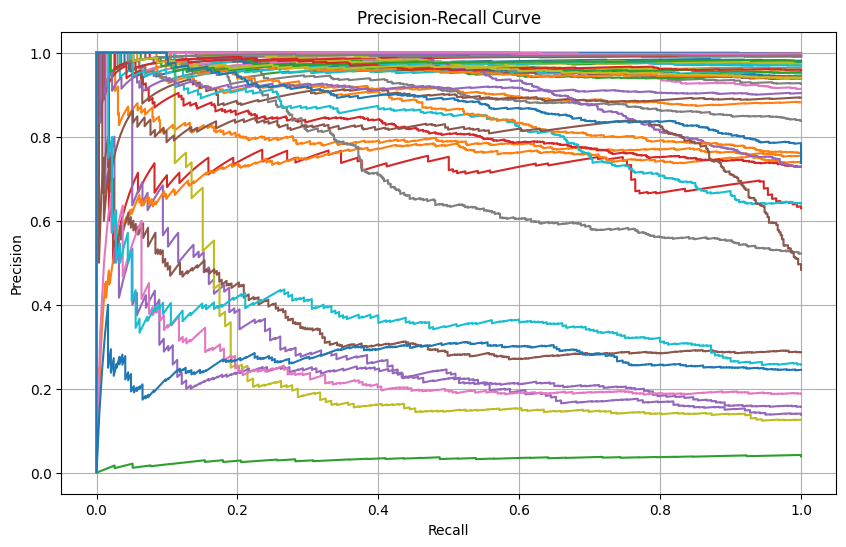

In [131]:
draw_precision_recall_curve(metric_profiles)
